In [97]:
import pandas as pd
import numpy as np
import mysql.connector
import seaborn as sns
import re
from functools import reduce
import pickle

def execute_query():
    config = {
            'user': 'user',
            'password': 'password',
            'port': '3307',
            'host': '127.0.0.1',
            'database': 'movies'
    }
    cnx = mysql.connector.connect(**config)
    df = pd.read_sql(query, cnx)
    cnx.close()
    return df

def multiple_col_one_hot(dataframe, col_names, prefix=''):
#     col_names = dataframe.columns
    base_df = pd.get_dummies(dataframe)
    dfs = []
    for col_name in col_names:
        temp_df = base_df.iloc[:, base_df.columns.str.match(str(col_name) + '_.+')]
        temp_df.columns = [prefix + re.search('^[^_]+_(.+)', x).group(1) for x in temp_df.columns]
        dfs.append(temp_df.replace(0, np.nan))
    result_df = reduce(lambda x, y: x.combine_first(y), dfs)
    return result_df.fillna(0).astype(int)

# country処理, size出したり国をdummy化したり
def process_country(dataframe):
    country_separated = dataframe.country.str.split(',', expand=True)
    # pythonの仕様としてboolが0, 1なので数値に矯正する
    b = country_separated.notnull() * 1
    dataframe['countrySize'] = b[0] + b[1] + b[2] + b[3]
    col_names = {0, 1, 2, 3}
    dummy_countries = multiple_col_one_hot(country_separated, col_names, 'CO')
    return  dataframe.join(dummy_countries)

# tag処理, size出したりタグをdummy化したり
def process_tag(dataframe):
    tag_separated = dataframe.tags.str.split(',', expand=True)
    b = tag_separated.notnull() * 1
    dataframe['tagSize'] = b[0] + b[1] + b[2]
    col_names = {0, 1, 2}
    dummy_tags = multiple_col_one_hot(tag_separated, col_names, 'TA')
    return dataframe.join(dummy_tags)

# genre, size出したりジャンルをdummy化したり
def process_genre(dataframe):
    genre_separated = dataframe.genres.str.split(',', expand=True)
    b = genre_separated.notnull() * 1
    dataframe['genreSize'] = b[0] + b[1] + b[2] + b[3]
    col_names = {0, 1, 2, 3}
    dummy_genres = multiple_col_one_hot(genre_separated, col_names, 'GE')
    return  dataframe.join(dummy_genres)

# class, 邦画か洋画か, ダミー変数は一つにする
def process_class(dataframe):
    dataframe['isJapanese'] = pd.get_dummies(pd.DataFrame(dataframe.clazz)).drop(columns=['clazz_洋画'])
    return dataframe

# 月の切り出し, 曜日抽出
def process_released(dataframe, month=True, weekday=True):
    if month:
        dataframe['releasedMonth'] = dataframe.released.astype(str).str[5:7].astype(int)
    if weekday:
        weekday = pd.to_datetime(dataframe.released).dt.dayofweek
        weekday = pd.DataFrame(weekday)
        df_weekday = pd.get_dummies(weekday.released, prefix='wd')
        dataframe = dataframe.join(df_weekday)
    return dataframe

def process_actor(dataframe):
    actor_separated = dataframe.actor.str.split(',', expand=True)
    col_names = {0, 1, 2, 3, 4, 5}
    dummy_actors = multiple_col_one_hot(actor_separated, col_names, 'AC')
    return dataframe.join(dummy_actors)

def process_director(dataframe):
    director_separated = dataframe.actor.str.split(',', expand=True)
    col_names = {0, 1}
    dummy_directors = multiple_col_one_hot(director_separated, col_names, 'DI')
    return dataframe.join(dummy_directors)

def process_pa(dataframe):
    df = dataframe
    model = predict_pa(df)
    coef = model.coef_
    intercept = model.intercept_
    df.loc[df.PA == 0, 'PA'] = convertZeroToPredict(df.loc[df.PA == 0].income, coef, intercept)
    
    df.PA.replace(0, 200)
    return df

def convertZeroToPredict(income, coef, intercept):
    y = income * coef + intercept
    return round(y)
    
def process_income(dataframe):
    a = dataframe.income
    income_ctgr = [0, 50, 100, 200, 300, 500, 700, 1000, 1500, 2000, 4000, 99999]
#     income_labels = ['0-50', '50-100', '100-200', '200-300', '300-500', '500-700', '700-1000', '1000-1500', '1500-2000', '2000-4000', '4000-']
    income_labels = [50, 100, 200, 300, 500, 700, 1000, 1500, 2000, 4000, 6000]
    dataframe['income'] = pd.cut(a, income_ctgr, labels=income_labels)
    return dataframe

def process_distribution(dataframe):
    agent = dataframe.distribution
    agent = agent.replace('東宝.*', 'toho', regex=True)
    agent = agent.replace('ワーナー.*', 'warner', regex=True)
    agent = agent.replace('アスミック.*', 'asmic', regex=True)
    agent = agent.replace('KADOKAWA.*', 'kadokawa', regex=True)
    agent = agent.replace('アニプレックス.*', 'aniplex', regex=True)
    agent = agent.replace('エイベックス.*', 'avex', regex=True)
    agent = agent.replace('東映.*', 'toei', regex=True)
    agent = agent.replace('GAGA.*', 'gaga', regex=True)
    agent = agent.replace('.*テアトル.*', 'teatol', regex=True)
    agent = agent.replace('松竹.*', 'shotiku', regex=True)
    agent = agent.replace('.*角川.*', 'kadokawa', regex=True)
    agent = agent.replace('.*ディズニー.*', 'disney', regex=True)
    agent = agent.replace('.*日活.*', 'toho', regex=True)
    agent = agent.replace('.*FOX.*', 'fox', regex=True)
    agent = agent.replace('.*イオン.*', 'aeon', regex=True)
    agent = agent.replace('.*パラマウント.*', 'paramount', regex=True)
    agent = agent.replace('.*ファントム.*', 'famtom', regex=True)
    agent = agent.replace('.*ショウゲート.*', 'showgate', regex=True)
    agent = agent.replace('.*SPE.*', 'spe', regex=True)
    tar = ['AMGエンタテインメント','BS-TBS','DLE','Elephant House','KATSU-do','KIRIYA PICTURES＝gaga','NAS','REGENTS','SDP','アップリンク','エル・ティー・コーポレーション','エレファントハウス','カラー','キノフィルムズ','クロックワークス','シンカ＝ハピネット','スターサンズ','スールキートス','ツイン','ティ・ジョイ','ティ・ジョイ＝shotiku','パルコ','ピクチャーズデプト','ブロードメディア・スタジオ','ブロードメディア・スタジオ＝カルチュア・パブリッシ','プレシディオ','プロダクションI.G＝ティ・ジョイ','ポニーキャニオン','マイシアター','マイシアター＝ライブ・ビューイング・ジャパン','ライブスポット（ＫＤＤＩ）','ライブ・ビューイング・ジャパン','ロングライド','ローソンHMVエンタテイメント','ヴィレッヂ＝ティ・ジョイ','東北新社','東和ピクチャーズ']
    agent = agent.replace(tar, 'Other')
    dummies = pd.get_dummies(agent, prefix='AG')
    return dataframe.join(dummies)

# シアターから地名を割り出す
# TODO: 頑張って系列の会社ラベリング頑張る
def process_theater(dataframe):
    place = dataframe.main_theater
    #dataframe['company'] = dataframe.main_theater
    place = place.replace('.*新宿.*', 'Shinjuku', regex=True)
    place = place.replace('.*丸の内.*', 'Marunouch', regex=True)
    place = place.replace('.*有楽.*', 'Yurakutyo', regex=True)
    place = place.replace('.*六本木.*', 'Roppongi', regex=True)
    place = place.replace('.*日本橋.*', 'Nihonbashi', regex=True)
    place = place.replace('.*渋谷.*', 'Shibuya', regex=True)
    place = place.replace('.*池袋.*', 'Ikebukuro', regex=True)
    place = place.replace('.*銀座.*', 'Ginza', regex=True)
    place = place.replace('.*板橋.*', 'Itabashi', regex=True)
    place = place.replace('.*シネマズ日劇.*', 'Yurakutyo', regex=True)
    place = place.replace('.*みゆき座.*', 'Yurakutyo', regex=True)
    place = place.replace('.*シャンテ.*', 'Yurakutyo', regex=True)
    place = place.replace('.*スカラ座.*', 'Yurakutyo', regex=True)
    place = place.replace('.*東劇.*', 'Ginza', regex=True)
    place = place.replace('.*錦糸町.*', 'Kinshityo', regex=True)
    place = place.replace('.*シネクイント.*', 'Shibuya', regex=True)
    place = place.replace('.*シネマカリテ.*', 'Shinjuku', regex=True)
    place = place.replace('.*スバル座.*', 'Yurakutyo', regex=True)
    place = place.replace('.*シネマメディアージュ.*', 'Odaiba', regex=True)
    place = place.replace('.*ル・シネマ.*', 'Shibuya', regex=True)
    place = place.replace('.*ワーナー・マイカル・シネマズ.*', 'Itabashi', regex=True)
    place = place.replace('.*東映邦画系.*', 'Other', regex=True)
    place = place.replace('.*ＴＯＥＩα.*', 'Other', regex=True)
    df_place = pd.get_dummies(place, drop_first=True, prefix='TH')
    return dataframe

def drop_columns(dataframe):
    df = dataframe.drop(columns=[
        'origin_creator', 'scenario', 'music', 'producer'])
    return df
    
def process(df_origin):
    dataframe = df_origin
    dataframe = process_pa(dataframe)
    dataframe = process_country(dataframe)
    dataframe = process_distribution(dataframe)
    dataframe = process_tag(dataframe)
    dataframe = process_genre(dataframe)
    dataframe = process_class(dataframe)
    dataframe = process_released(dataframe, month=True, weekday=False)
    dataframe = process_actor(dataframe)
    dataframe = process_director(dataframe)
#     dataframe = process_theater(dataframe)
#     dataframe = process_income(dataframe)
    return dataframe

In [72]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

def linearregression(dataframe):
    df = dataframe
    x = df.drop(columns=['income'])
    y = df.income
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1000)
    
    clf = linear_model.LinearRegression().fit(x_train, y_train)
    return clf, x_test, y_test, x_train, y_train

def linerregression_for_pa(dataframe):
    df = dataframe
    x = pd.DataFrame(df.income)
    y = df.PA
    clf = linear_model.LinearRegression().fit(x, y)
    return clf

def linearregressionN(dataframe, n):
    df = dataframe
    x = df.drop(columns=['income'])
    y = df.income
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1000)
 
    # n次の項まで作成
    d = n
    clf = Pipeline([
        ('poly', PolynomialFeatures(degree=d)),
        ('linear', linear_model.LinearRegression())
    ])
    clf.fit(x_train, y_train)

    # make predictions
#     xt = np.linspace(0.0, 12.0, num=1000).reshape((1000, 1))
#     yt = regr.predict(xt)
    # plot regression result
#     plt.plot(xt, yt, label='polynomial of degree %d' % (d))
    
    return clf, x_test, y_test, x_train, y_train

def elastic(dataframe):
    df = dataframe
    x = df.drop(columns=['income'])
    y = df.income
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1000)
    clf = linear_model.ElasticNet(fit_intercept=True, normalize=False).fit(x_train, y_train)
    return clf, x_test, y_test, x_train, y_train

def randomforest(dataframe):
    df = dataframe
    x = df.drop(columns=['income'])
    y = df.income
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1000)
    # RandomForest にグリッドサーチを適用
    parameters = {
        "n_estimators":[i for i in range(100,150,2)],
        "criterion":["gini","entropy"],
        "max_depth":[i for i in range(40, 60, 2)],
        "random_state":[3],
    }

    clf = GridSearchCV(RandomForestClassifier(), parameters, cv=3)
    clf_fit = clf.fit(x_train, y_train)
    predictor = clf_fit.best_estimator_
    return predictor, x_test, y_test, x_train, y_train, clf_fit

def sgd(dataframe):
    df = dataframe
    x = df.drop(columns=['income'])
    y = df.income
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1000)
    clf = linear_model.SGDRegressor().fit(x_train, y_train)
    return clf, x_test, y_test, x_train, y_train

def rfr(dataframe):
    df = dataframe
    x = df.drop(columns=['income'])
    y = df.income
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1000)
    
    params = {'n_estimators'  : [3, 10, 100, 1000, 10000], 'n_jobs': [-1]}
    cv = GridSearchCV(RandomForestRegressor, params, cv = 3, scoring= 'mean_squared_error', n_jobs =1)
    clf_fit = cv.fit(x_train, y_train)
    predictor = clf_fit.best_estimator_
    return predictor, x_test, y_test

def ridge(dataframe):
    df = dataframe
    x = df.drop(columns=['income'])
    y = df.income
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1000)
    parameters = {
        "alpha": np.logspace(-2, 4, 24)
    }
    clf = GridSearchCV(Ridge(), parameters, cv=3)
    clf_fit = clf.fit(x_train, y_train)
    predictor = clf_fit.best_estimator_
    return predictor, x_test, y_test

def svr_with_gaussian(dataframe):
    df = dataframe
    x = df.drop(columns=['income'])
    y = df.income
        
    # 標準化
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1000)
    
    params_cnt = 20
    params = {"C":np.logspace(0,2,params_cnt), "epsilon":np.logspace(-1,1,params_cnt)}
    clf = GridSearchCV(SVR(kernel='rbf', gamma='auto'), params, cv=3)
    clf_fit = clf.fit(x_train, y_train)
    predictor = clf_fit.best_estimator_
    return predictor, x_test, y_test

In [69]:
def predict_linear(dataframe):
    model, x_test, y_test, x_train, y_train = linearregression(dataframe)
    print('切片: ', model.intercept_)
    print('決定係数 test: ', model.score(x_test, y_test))
    diff_by_income(model, x_test, y_test)
    return model, x_test, y_test

def predict_elastic(dataframe):
    model, x_test, y_test, x_train, y_train = elastic(dataframe)
    print('切片: ', model.intercept_)
    print('決定係数 test: ', model.score(x_test, y_test))
    diff_by_income(model, x_test, y_test)
    return model, x_test, y_test

def predict_linearN(dataframe, n):
    model, x_test, y_test, x_train, y_train = linearregressionN(dataframe, n)
#     print('切片: ', model.intercept_)
    print('決定係数 test: ', model.score(x_test, y_test))
    diff_by_income(model, x_test, y_test)
    return model, x_test, y_test

def predict_sgd(dataframe):
    model, x_test, y_test, x_train, y_train = sgd(dataframe)
    print('切片: ', model.intercept_)
    print('決定係数 test: ', model.score(x_test, y_test))
    diff_by_income(model, x_test, y_test)
    return model, x_test, y_test

# 欠損してるPA値を補完するためのもの
def predict_pa(dataframe):
    # 0でないものを予測に使う
    df = dataframe.query('income != 0')
    return linerregression_for_pa(df)

def predict_rforest(dataframe):
    model, x_test, y_test, x_train, y_train, grid_model = randomforest(dataframe)
    print('score: ', model.score(x_test, y_test))
#     diff_by_income(model, x_test, y_test)
    return model, x_test, y_test, x_train, y_train, grid_model

def predict_rfr(dataframe):
    model, x_test, y_test = rfr(dataframe)
    print('score: ', model.score(x_test, y_test))
    return model, x_test, y_test

def predict_ridge(dataframe):
    model, x_test, y_test = ridge(dataframe)
    print('score: ', model.score(x_test, y_test))
    diff_by_income(model, x_test, y_test)
    return model, x_test, y_test

def predict_svr(dataframe):
    model, x_test, y_test =  svr_with_gaussian(dataframe)
    print('score: ', model.score(x_test, y_test))
    diff_by_income(model, x_test, y_test)
    return model, x_test, y_test

def diff_by_income(model, x, y):
    a = pd.DataFrame(model.predict(x)).join(y.reset_index().drop('index', axis=1))
    a['diff'] = (a[0] - a.income).abs()
    print(a.sort_values('income', ascending=False).head(10))

# GridSearchCVの結果をヒートマップで表示する。
def plot_heatmap_from_grid(grid):
    # チューニング対象のパラメータを特定する。
    params = [k for k in grid.cv_results_.keys() if k.startswith('param_')]
    if len(params) != 2:
        print(len(params))
        raise Exception('grid has to have exact 2 parameters.') 

    # ヒートマップの行、列、値に使うキーを定義する。
    index = params[0]
    columns = params[1]
    values = 'mean_test_score'

    # gridから必要なキーのみを抽出する。
    df_dict = {k: grid.cv_results_[k] for k in grid.cv_results_.keys() & {index, columns, values}}

    # dictをDataFrameに変換してseabornでヒートマップを表示する。
    import pandas as pd
    df = pd.DataFrame(df_dict)
    data = df.pivot(index=index, columns=columns, values=values)
    import seaborn as sns
    sns.heatmap(data, annot=True, fmt='.3f')

def dump_model(model, x, y, name):
    # モデルを保存する
    filename = 'models/' + name
    pickle.dump(model, open(filename + '.sav', 'wb'))
    pickle.dump(x, open(filename + '_x_test.pd', 'wb'))
    pickle.dump(y, open(filename + '_y_test.pd', 'wb'))

In [70]:
def execute():
    df_origin = execute_query()
    df_origin.columns
    df = process(drop_columns(df_origin))
    df = df.drop(columns=[
        'actor', 'director', 'main_theater', 'released', 'distribution', 'country', 'tags', 'genres', 'clazz'])
    return df

df = execute()

In [88]:
df_origin = execute_query()
df_origin.head()

,product_year,time,country,tags,genres,actor,origin_creator,scenario,music,director,clazz,distribution,released,income,PA,main_theater,producer
0,2010,82,アメリカ,"コミカル,かわいい,笑える","コメディ,ファミリー","クリスティナ・アップルゲイト,マイケル・クラーク・ダンカン,ニール・パトリック・ハリス,ショ...",None,"ロン・J・フリードマン,スティーヴ・ベンチック",クリストファー・レナーツ,ブラッド・ペイトン,洋画,ワーナー,2010-08-21,303,285,丸の内ルーブル,"ブルース・バーマン,ブレント・オコナー"
1,2016,100,日本,"コミカル,笑える,楽しい",コメディ,"松山ケンイチ,倉科カナ,溝端淳平,田山涼成,笹野高史",漫☆画太郎,松原秀,森野宣彦,山口雄大,邦画,東映,2016-02-27,35,30,新宿バルト９,None
2,2015,117,日本,"切ない,ファンタジー,不思議",ドラマ,"中村倫也,新井浩文,佐々木希,菅田将暉,杏",None,前田こうこ,渡邊崇,柳沢翔,邦画,ファントム・フィルム,2016-03-05,25,50,新宿バルト９,None
3,2016,105,日本,"かわいい,ファンタジー,セクシー","ロマンス,ファンタジー","韓英恵,渋川清彦,真木よう子,大杉漣,二階堂ふみ",室生犀星,港岳彦,"森俊之,勝本道哲",石井岳龍,邦画,ファントム・フィルム,2016-04-01,60,25,新宿バルト９,None
4,2016,120,日本,"切ない,不気味,絶望的",ドラマ,"新井浩文,三浦友和,南果歩,若葉竜也,田中麗奈",None,None,窪田ミナ,赤堀雅秋,邦画,ファントム・フィルム,2016-06-18,52,25,新宿バルト９,None


In [73]:
model_rfr, x_rfr, y_rfr = predict_rfr(df)

ValueError: 'mean_squared_error' is not a valid scoring value. Use sorted(sklearn.metrics.SCORERS.keys()) to get valid options.

In [71]:
model_rfc, x_frc, y_rfc, x_train, y_train, grid_model = predict_rforest(df)

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


score:  0.256198347107438


In [1597]:
def barplot_feature_importance(model):
    feature = model.feature_importances_
    f = pd.DataFrame({'number': range(0, len(feature)), 'feature': feature[:]})
    f2 = f.sort_values('feature',ascending=False)
    f3 = f2.ix[:, 'number']
    # 特徴の名前
    label = df.columns[0:]
    # 降順
    indices = np.argsort(feature)[::-1]
    
    for i in range(feature):
        print(str(i + 1) + " " + str(label[indices[i]]) + " " + str(feature[indices[i]]))
    plt.title('Feature Importance')
    plt.bar(range(len(feature)), feature[indices], color='lightblue', align='center')
    plt.xticks(range(lent(feature)), label[indices], rotation=90)
    plt.xlim([-1, len(feature)])
    plt.tight_layout()
    plt.show()    

In [64]:
model_svr, x_svr, y_svr = predict_svr(df)

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


score:  -0.03779089123136359
              0  income         diff
20   461.645810    9530  9068.354190
8    641.540114    6860  6218.459886
2    495.335138    5220  4724.664862
112  551.619551    4700  4148.380449
54   593.806627    4240  3646.193373
21   527.951816    3610  3082.048184
114  520.739378    3500  2979.260622
123  554.599123    3010  2455.400877
53   517.203743    2910  2392.796257
69   536.843399    2740  2203.156601


In [39]:
def predict_by_model(model_name):
    clf = pickle.load(open('models/' + model_name + '.sav', mode='rb'))
    x_test = pickle.load(open('models/' + model_name + '_x_test.pd', mode='rb'))
    y_test = pickle.load(open('models/' + model_name + '_y_test.pd', mode='rb'))
    score = clf.score(x_test, y_test)
    return score

In [40]:
predict_by_model('ridge_model')

0.5920267775827319


0.5920267775827319

In [28]:
model_ridge.score(x_ridge, y_ridge)

0.5920267775827319

In [26]:
dump_model(model_ridge, x_ridge, y_ridge, 'ridge_model')

In [10]:
model_ridge, x_ridge, y_ridge = predict_ridge(df)

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


score:  0.5920267775827319
               0  income         diff
20   3069.291359    9530  6460.708641
8    4595.447361    6860  2264.552639
2    2736.800872    5220  2483.199128
112  2226.814868    4700  2473.185132
54    741.167618    4240  3498.832382
21   3397.115823    3610   212.884177
114  3348.743601    3500   151.256399
123  1654.018653    3010  1355.981347
53   2842.135898    2910    67.864102
69   2460.635747    2740   279.364253


In [59]:
len(df.columns)

2769

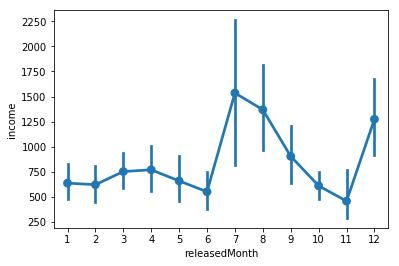

In [58]:
sns.pointplot('releasedMonth', 'income', data=df)

In [76]:
model_ela, x_ela, y_ela = predict_elastic(df)

切片:  -3491.233167179026
決定係数 test:  0.5904226417149083
               0  income         diff
20   3177.417891    9530  6352.582109
8    3924.326475    6860  2935.673525
2    2784.791899    5220  2435.208101
112  2061.873103    4700  2638.126897
54    848.478691    4240  3391.521309
21   3415.367407    3610   194.632593
114  3332.997199    3500   167.002801
123  1533.440478    3010  1476.559522
53   2774.100387    2910   135.899613
69   2525.199278    2740   214.800722


In [75]:
model_lin, x_lin, y_lin = predict_linear(df)

切片:  -83074.86359544509
決定係数 test:  -0.6150450615868293
                0  income         diff
20    2680.751302    9530  6849.248698
8    10687.632376    6860  3827.632376
2     1348.241931    5220  3871.758069
112   2524.601774    4700  2175.398226
54     186.681924    4240  4053.318076
21    2893.954600    3610   716.045400
114   3280.393453    3500   219.606547
123   3123.011865    3010   113.011865
53    5228.348742    2910  2318.348742
69     629.613895    2740  2110.386105


In [ ]:
model_lin, x_lin, y_lin = predict_linearN(df, 3)

In [8]:
model_sgd, x_sgd, y_sgd = predict_sgd(df)

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


切片:  [1.19093671e+09]
決定係数 test:  -2.1126838591735105e+25
                0  income          diff
20   5.989539e+15    9530  5.989539e+15
8    6.031881e+15    6860  6.031881e+15
2    5.921326e+15    5220  5.921326e+15
112  5.728912e+15    4700  5.728912e+15
54   5.517769e+15    4240  5.517769e+15
21   6.022841e+15    3610  6.022841e+15
114  5.952862e+15    3500  5.952862e+15
123  5.532613e+15    3010  5.532613e+15
53   5.810196e+15    2910  5.810196e+15
69   5.822649e+15    2740  5.822649e+15


In [65]:
len(df.columns)

2769

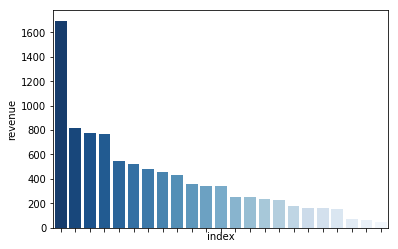

In [230]:
a = pd.concat([df.income, df.COアイルランド, df.COアメリカ, df.COイギリス, df.COイタリア, df.COオーストラリア, df.COカナダ, df.COスイス, df.COスウェーデン, df.COスペイン, df.COトルコ, df.COドイツ, df.COニュージーランド, df.COフィンランド, df.COフランス, df.COベルギー, df.COメキシコ, df.COルクセンブルク, df.COルーマニア, df.CO中国, df.CO南アフリカ, df.CO日本, df.CO韓国, df.CO香港], axis=1)
b = pd.DataFrame()
for i in a.columns:
    if i == 'income':
        continue
    c = a[a[i] == 1].groupby(i).median().income
    b = b.append(c).rename(index={'income': i})
b = b.rename(columns={1: 'revenue'}).sort_values('revenue', ascending=False).reset_index()
fig = sns.barplot('index', 'revenue', data=b, palette='Blues_r')
fig.tick_params(labelbottom=False)

In [231]:
b

,index,revenue
0,COニュージーランド,1695.0
1,COトルコ,820.0
2,COルーマニア,780.0
3,COスペイン,770.0
4,COアメリカ,550.0
5,COオーストラリア,520.5
6,COフランス,480.0
7,COイギリス,458.0
8,CO日本,430.0
9,COベルギー,359.0


In [20]:
df

,product_year,time,income,PA,countrySize,COアイルランド,COアメリカ,COイギリス,COイタリア,COオーストラリア,...,GEファンタジー,GEホラー,GEミュージカル,GEロマンス,GE戦争,GE特撮,GE西部劇,GE青春,isJapanese,releasedMonth
0,2010,82,303,285.0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,8
1,2016,100,35,30.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
2,2015,117,25,50.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
3,2016,105,60,25.0,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,4
4,2016,120,52,25.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,6
5,2016,93,33,23.0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,7
6,2016,123,20,17.0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,7
7,2015,103,24,34.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,7
8,2016,116,50,100.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,9
9,2016,92,30,100.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,10


In [25]:
df[['income', 'countrySize']].groupby('countrySize').describe()['income']

,count,mean,std,min,25%,50%,75%,max
countrySize,,,,,,,,
1,553.0,814.801085,1047.858079,12.0,230.0,480.0,1000.0,9530.0
2,33.0,1111.515152,2034.373907,45.0,127.0,294.0,1200.0,9670.0
3,11.0,270.727273,261.613108,47.0,77.5,160.0,335.5,850.0
4,5.0,849.000000,680.867094,75.0,670.0,770.0,780.0,1950.0


In [14]:
a = df[['income', 'countrySize']]
b = a.groupby('countrySize').describe()
c = b.income.reset_index()
c[['countrySize', 'count', 'mean', '50%']]

,countrySize,count,mean,50%
0,1,553.0,814.801085,480.0
1,2,33.0,1111.515152,294.0
2,3,11.0,270.727273,160.0
3,4,5.0,849.000000,770.0


In [ ]:
pd.DataFrame()

In [15]:
b

income                                                        \
             count         mean          std   min    25%    50%     75%   
countrySize                                                                
1            553.0   814.801085  1047.858079  12.0  230.0  480.0  1000.0   
2             33.0  1111.515152  2034.373907  45.0  127.0  294.0  1200.0   
3             11.0   270.727273   261.613108  47.0   77.5  160.0   335.5   
4              5.0   849.000000   680.867094  75.0  670.0  770.0   780.0   

                     
                max  
countrySize          
1            9530.0  
2            9670.0  
3             850.0  
4            1950.0

In [16]:
b.reset_index()

countrySize income                                                        \
               count         mean          std   min    25%    50%     75%   
0           1  553.0   814.801085  1047.858079  12.0  230.0  480.0  1000.0   
1           2   33.0  1111.515152  2034.373907  45.0  127.0  294.0  1200.0   
2           3   11.0   270.727273   261.613108  47.0   77.5  160.0   335.5   
3           4    5.0   849.000000   680.867094  75.0  670.0  770.0   780.0   

           
      max  
0  9530.0  
1  9670.0  
2   850.0  
3  1950.0

In [19]:
b.reset_index().reset_index()

index countrySize income                                                \
                     count         mean          std   min    25%    50%   
0     0           1  553.0   814.801085  1047.858079  12.0  230.0  480.0   
1     1           2   33.0  1111.515152  2034.373907  45.0  127.0  294.0   
2     2           3   11.0   270.727273   261.613108  47.0   77.5  160.0   
3     3           4    5.0   849.000000   680.867094  75.0  670.0  770.0   

                   
      75%     max  
0  1000.0  9530.0  
1  1200.0  9670.0  
2   335.5   850.0  
3   780.0  1950.0

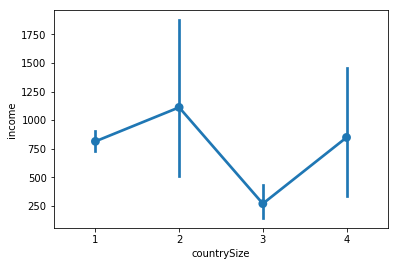

In [14]:
sns.pointplot('countrySize', 'income', data=df)

/Users/y.nakamori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


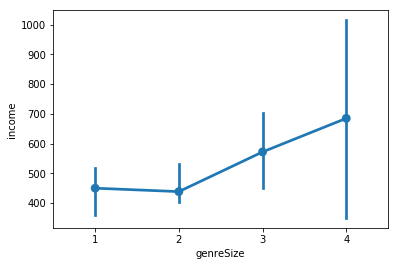

In [56]:
sns.pointplot('genreSize', 'income', data=df, estimator=np.median)

In [222]:
df[['income', 'genreSize']].groupby('genreSize').describe()

income                                                         \
           count         mean          std   min     25%    50%     75%   
genreSize                                                                 
1          199.0   745.311558   938.104167  20.0  200.00  450.0   890.0   
2          256.0   788.238281  1036.198067  12.0  210.00  438.5   952.5   
3          117.0   875.418803  1179.190855  24.0  260.00  572.0   990.0   
4           30.0  1398.600000  2085.312523  54.0  220.75  685.0  1132.5   

                   
              max  
genreSize          
1          6860.0  
2          9530.0  
3          9670.0  
4          8960.0

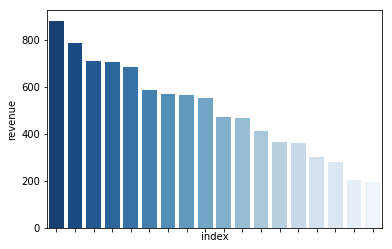

In [236]:
a = pd.concat([df.income,df.GESF,df.GEその他,df.GEアクション,df.GEアドベンチャー ,df.GEアニメ ,df.GEコメディ ,df.GEサスペンス ,df.GEドキュメンタリー ,df.GEドラマ,df.GEファミリー ,df.GEファンタジー ,df.GEホラー ,df.GEミュージカル ,df.GEロマンス,df.GE戦争 ,df.GE特撮,df.GE西部劇 ,df.GE青春], axis=1)
b = pd.DataFrame()
for i in a.columns:
    if i == 'income':
        continue
    c = a[a[i] == 1].groupby(i).median().income
    b = b.append(c).rename(index={'income': i})
b = b.rename(columns={1: 'revenue'}).sort_values('revenue', ascending=False).reset_index()
fig = sns.barplot('index', 'revenue', data=b, palette='Blues_r')
fig.tick_params(labelbottom=False)



In [239]:
b

,index,revenue
0,GE特撮,880.0
1,GEアドベンチャー,785.0
2,GESF,709.0
3,GEアクション,705.0
4,GEアニメ,685.0
5,GE戦争,584.0
6,GEファミリー,570.0
7,GEファンタジー,566.0
8,GEその他,550.0
9,GEサスペンス,470.0


In [6]:
query = '''
WITH tag AS (
    select
        movie_id
        ,group_concat(tag_name) as tags
    from
        yahoo_movie_tag
        inner join yahoo_tag
            on yahoo_movie_tag.tag_id = yahoo_tag.tag_id
    group by movie_id
), 
    genre AS (
    select
        movie_id
        ,group_concat(genre_name) as genres
    from
        yahoo_movie_genre
        inner join yahoo_genre
            on yahoo_movie_genre.genre_id = yahoo_genre.genre_id
    group by movie_id
),
    staff AS (
    select
        movie_id
        ,MAX(CASE WHEN staff_role = '俳優' THEN staff_names END) as actor
        ,MAX(CASE WHEN staff_role = '原作' THEN staff_names END) as origin_creator
        ,MAX(CASE WHEN staff_role = '脚本' THEN staff_names END) as scenario
        ,MAX(CASE WHEN staff_role = '音楽' THEN staff_names END) as music
        ,MAX(CASE WHEN staff_role = '監督' THEN staff_names END) as director
        ,MAX(CASE WHEN staff_role = '製作総指揮' THEN staff_names END) as producer
    from
    (
        select
            movie_id
            ,staff_role
            ,group_concat(staff_name) as staff_names
        from
            yahoo_movie_staff
            inner join yahoo_staff
                on yahoo_movie_staff.staff_id = yahoo_staff.staff_id
        where
            role_rank in (0, 1, 2, 3, 4, 5)
        group by
            movie_id
            ,staff_role
    ) as staff_tmp
    group by movie_id
),
    yahoo_movies AS (
        select
            yahoo_movie.movie_id
            ,yahoo_movie.product_year
            ,yahoo_movie.screening_time
            ,yahoo_movie.country
            ,tag.tags
            ,genre.genres
            ,staff.actor
            ,staff.origin_creator
            ,staff.scenario
            ,staff.music
            ,staff.director
            ,staff.producer
        from
            yahoo_movie
            inner join tag
                on yahoo_movie.movie_id = tag.movie_id
            inner join genre
                on yahoo_movie.movie_id = genre.movie_id
            inner join staff
                on yahoo_movie.movie_id = staff.movie_id
)

select
    yahoo_movies.product_year
    ,yahoo_movies.screening_time as time
    ,yahoo_movies.country
    ,yahoo_movies.tags
    ,yahoo_movies.genres
    ,yahoo_movies.actor
    ,yahoo_movies.origin_creator
    ,yahoo_movies.scenario
    ,yahoo_movies.music
    ,yahoo_movies.director
    ,origin_movie.class as clazz
    ,origin_movie.distribution
    ,origin_movie.released_at as released
    ,origin_movie.box_office_revenue as income
    ,CAST(origin_movie.P_and_A as UNSIGNED) as PA
    ,origin_movie.main_theater
,yahoo_movies.producer
from
    origin_movie
    inner join yahoo_movies
        on origin_movie.y_movie_id = yahoo_movies.movie_id
where
    origin_movie.box_office_revenue != 0
    and origin_movie.P_and_A != 0
;
    '''